In [1]:
import os

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-search-indexing"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-ai-search-indexing


In [2]:
import os
import requests
import base64

In [3]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Setting up the deployment name
deployment_name = os.getenv('AZURE_OPENAI_API_DEPLOYMENT_NAME_VISION')

# The base URL for your Azure OpenAI resource. e.g. "https://<your resource name>.openai.azure.com"
openai_api_base = os.getenv('AZURE_OPENAI_ENDPOINT_VISION')

# The API key for your Azure OpenAI resource.
openai_api_key = os.getenv('AZURE_OPENAI_API_KEY_VISION')

# Currently OPENAI API have the following versions available: 2022-12-01. All versions follow the YYYY-MM-DD date structure.
openai_api_version = os.getenv('AZURE_OPENAI_API_VERSION_VISION')

In [4]:
# Define GPT-4V API call with image
def call_GPT4V_image(messages, ocr=False, grounding=False, in_context=None, vision_api=None):
    # Construct the API request URL
    if ocr or grounding or in_context is not None:
        api_url = f"{openai_api_base}/openai/deployments/{deployment_name}/extensions/chat/completions?api-version={openai_api_version}"
    else:
        api_url = f"{openai_api_base}/openai/deployments/{deployment_name}/chat/completions?api-version={openai_api_version}"

    # Including the api-key in HTTP headers
    headers = {
        "Content-Type": "application/json",
        "api-key": openai_api_key,
    }

    # Payload for the request
    payload = {
        "model": "gpt-4-vision-preview",
        "messages": messages,
        "temperature": 0.7,
        "top_p": 0.95,
        "max_tokens": 800
    }

    if ocr or grounding:
        payload["enhancements"]={
              "ocr": {
                "enabled": ocr # Enable OCR enhancement
              },
              "grounding": {
                "enabled": grounding  # Enable grounding enhancement
              }
        }

    data_sources = []

    if in_context is not None:
        data_sources.append({
            "type": "AzureCognitiveSearch",
            "parameters": {
                "endpoint": in_context.get("endpoint"),
                "key": in_context.get("key"),
                "indexName": in_context.get("indexName"),
            }
        })

    if vision_api is not None:
        data_sources.append({
            "type": "AzureComputerVision",
            "parameters": {
                "endpoint": vision_api.get("endpoint"),
                "key": vision_api.get("key"),
            }
        })

    if data_sources:
        payload["dataSources"] = data_sources

    # Send the request and handle the response
    try:
        response = requests.post(api_url, headers=headers, json=payload)
        response.raise_for_status()  # Raise an error for bad HTTP status codes
        return response.json()
    except requests.RequestException as e:
        raise SystemExit(f"Failed to make the request. Error: {e}")

In [5]:
#%pip install pdf2image
#conda install -c conda-forge poppler
#%pip install PyMuPDF
# Example Usage
pdf_path = 'C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-search-indexing\\notebooks\\dev\\instruction-manual-fisher-ewd-ews-ewt-valves-through-nps-12x8-en-124788.pdf'  # Replace with your PDF file path
output_folder = 'C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-search-indexing\\notebooks\\dev\\images'  # Replace with your desired output folder path

In [21]:
from pdf2image import convert_from_path
import os

def convert_pdf_to_images(pdf_path, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert PDF to list of images
    images = convert_from_path(pdf_path)

    # Save each page as an image
    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f'page_{i+1}.jpg')
        image.save(image_path, 'JPEG')

    print(f"Conversion complete. Images saved in {output_folder}")

In [10]:
import glob, fitz
from IPython.display import display, Image
import os

# To get better resolution
zoom_x = 2.0  # horizontal zoom
zoom_y = 2.0  # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension

path = 'C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-search-indexing\\notebooks\\dev\\'
all_files = glob.glob(path + "*.pdf")

for filename in all_files:
    doc = fitz.open(filename)  # open document
    base_filename = os.path.basename(filename)  # get the base filename
    base_filename = os.path.splitext(base_filename)[0]  # remove the extension
    for page in doc:  # iterate through the pages
        pix = page.get_pixmap(matrix=mat)  # render page to an image
        pix.save("C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-search-indexing\\notebooks\\dev\\images\\{}-page-{}.png".format(base_filename, page.number))  # store image as a PNG

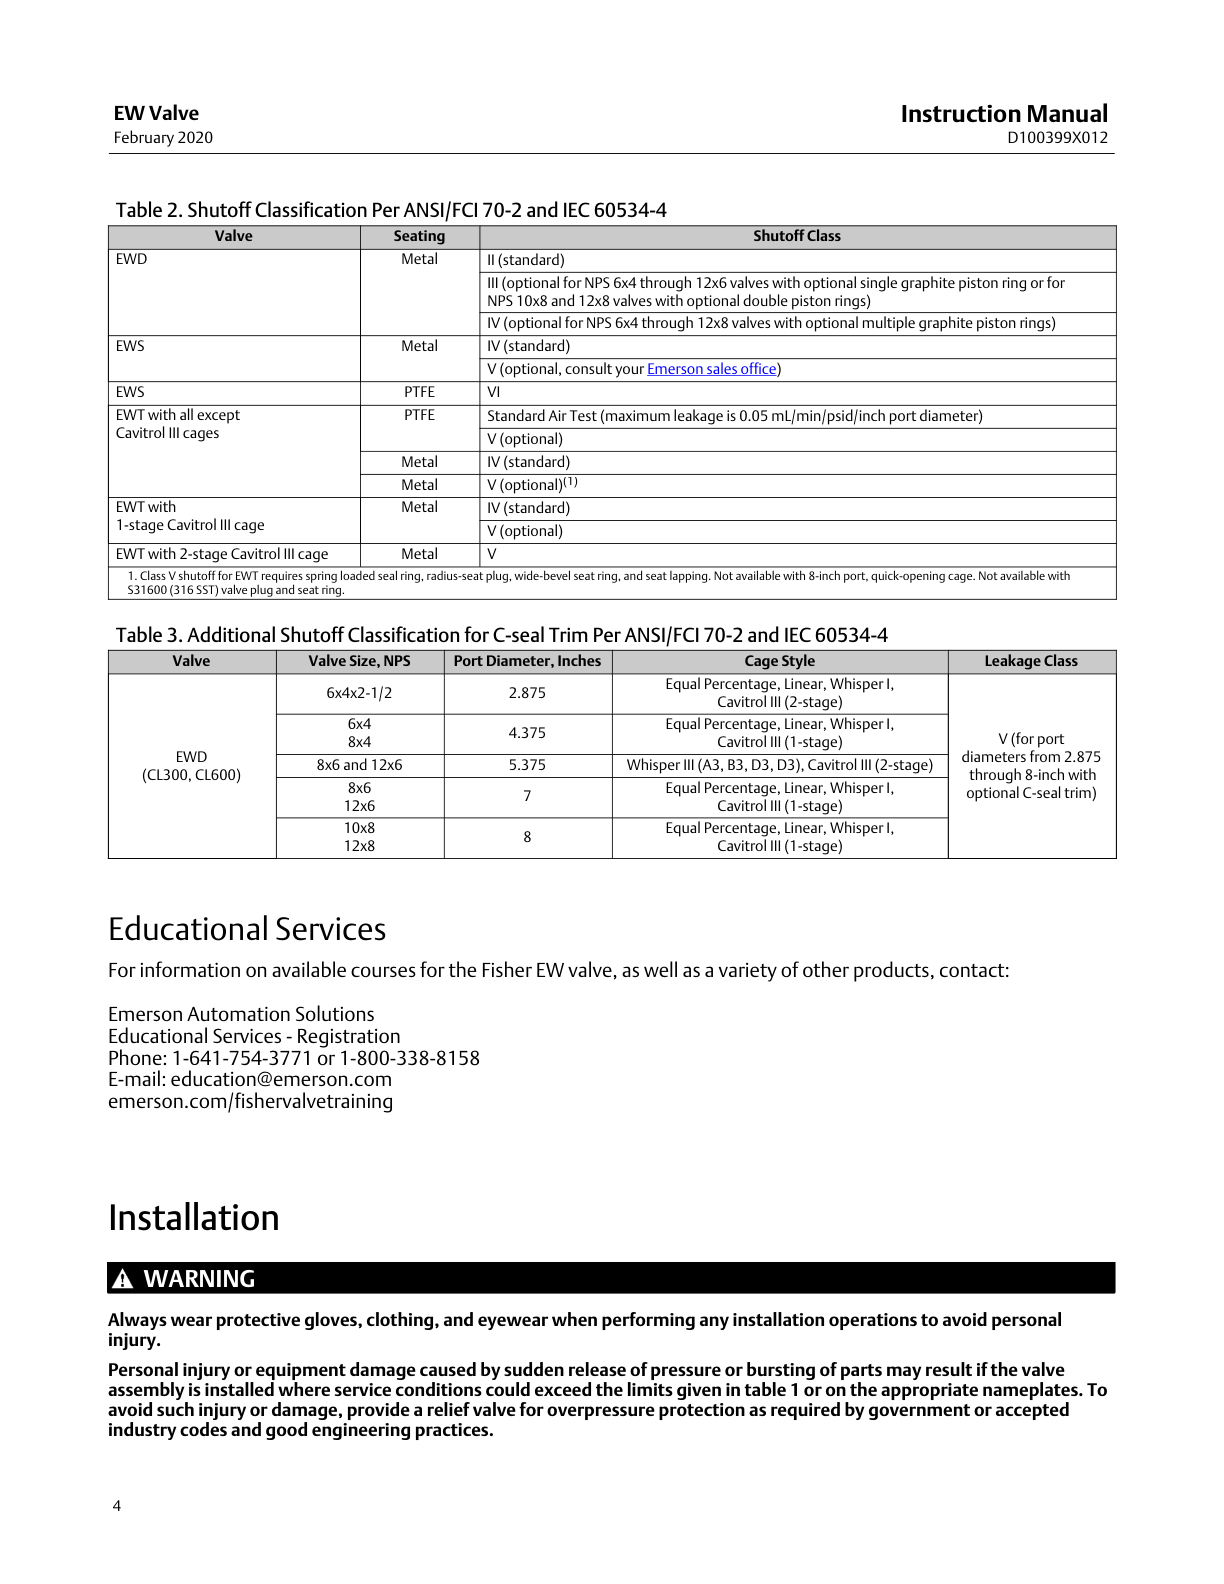

Summary:
This document is an instruction manual for the EW Valve, dated February 2020, and provides detailed information regarding the shutoff classification per ANSI/FCI 70-2 and IEC 60534-4 standards for various configurations of the EW Valve. It also includes additional shutoff classification for the C-seal trim. The manual emphasizes the importance of wearing protective gear during installation to avoid injury and warns about the potential for personal injury or equipment damage if the valve assembly is installed in conditions exceeding the limits provided in the manual or nameplates.

Key Information and Details:

- **Table 2: Shutoff Classification Per ANSI/FCI 70-2 and IEC 60534-4**
  - EWD Valve with Metal Seating: 
    - Shutoff Class II is standard.
    - Shutoff Class III is optional for NPS 6x4 through 12x6 with a single graphite piston ring or NPS 10x8 and 12x8 with double piston rings.
    - Shutoff Class IV is optional for NPS 6x4 through 12x8 with multiple graphite pist

In [11]:
image_file_path = "C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-search-indexing\\notebooks\\dev\\images\\instruction-manual-fisher-ewd-ews-ewt-valves-through-nps-12x8-en-124788-page-3.png"  # Update with your image path
sys_message = "You are an AI assistant capable of processing and summarizing complex documents with diagrams and tables."
user_prompt = '''Can you analyze this document? Please provide a summary first and then include key information and details from tables and diagrams as bullet points.
I need all the information in detail and with a lot of granularity to make sure all the details are captured. The intention is another system will read this information and understand
in detail the context and be able to answer precise questions.'''

# Encode the image in base64
with open(image_file_path, 'rb') as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

messages = [
    {
      "role": "system",
      "content": [
          {
            "type": "text", 
            "text": sys_message
          }
      ]
    },
    {
      "role": "user",
      "content": [
          {
            "type": "text",
            "text": user_prompt # Prompt for the user
          },
          {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encoded_image}" # Image to be processed
          }
          }
      ]
    }
  ]

# vision_api_config = {
#     "endpoint": vision_api_endpoint,
#     "key": vision_api_key
# }

try:
    response_content = call_GPT4V_image(messages, ocr=True, vision_api=None)
    display(Image(image_file_path)) 
    print(response_content['choices'][0]['message']['content'])  # Print the content of the response
except Exception as e:
    raise SystemExit(f"Failed to call GPT-4V API. Error: {e}")